### Objective

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.

### Suggestions

- You could build a machine learning model that predicts how much someone will spend based on demographics and offer type.
- Or you could build a model that predicts whether or not someone will respond to an offer.
- Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Starbucks

The project uses the [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) process and is divided into the following parts:

## 1. Business understanding

Some questions we might want to answer are:

- What is the expected value that each customer will spend?
- What are the characteristics and behaviors that predict how much a customer will spend?
- Which offer type should be send depending on the predicted value the customer will spend?
- Who are the customers that have a high probability of completing an offer?
- Which channels are better for each demographic?
- What was the return on investment (ROI) of the current experiment and how does it compare to the proposed solution?

Since we have access to the experiment data containing only the treatment, we will take a simpler approach to solve this problem, which is ______.

But if we consider a scenario where we work at Starbucks and have access to data from other customers, a great approach would be to use [uplift models](https://www.youtube.com/watch?v=2J9j7peWQgI&t=1359s), from the [causalml library](https://github.com/uber/causalml). With that, we could use:
- [S, T or X Meta-learners](https://causalml.readthedocs.io/en/latest/methodology.html#meta-learner-algorithms). Provided that this experiment was an A/B test and had a control group. [[1]](https://www.pnas.org/content/pnas/116/10/4156.full.pdf)
- [R Meta-learner](https://causalml.readthedocs.io/en/latest/methodology.html#r-learner). Provided that we had a pool of customers that did not receive any offer, to be able to build a balanced control and compare it against the treatment. [[2]](https://arxiv.org/pdf/1712.04912.pdf)

[[1]](https://www.pnas.org/content/pnas/116/10/4156.full.pdf) Künzel, Sören R., et al. "Metalearners for estimating heterogeneous treatment effects using machine learning." Proceedings of the national academy of sciences 116.10 (2019): 4156-4165.

[[2]](https://arxiv.org/pdf/1712.04912.pdf) Nie, Xinkun, and Stefan Wager. "Quasi-oracle estimation of heterogeneous treatment effects." arXiv preprint arXiv:1712.04912 (2017).

## 2. Data understanding

### 2.1. Importing libraries

In [265]:
import numpy as np
import pandas as pd
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("./style/minimal.mplstyle")

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format="retina"

### 2.2. Loading data

In [296]:
portfolio = pd.read_json("data/portfolio.json", orient="records", lines=True)
profile = pd.read_json("data/profile.json", orient="records", lines=True)
transcript = pd.read_json("data/transcript.json", orient="records", lines=True)

In [267]:
print("Portfolio shape: ", portfolio.shape)
print("Profile shape:   ", profile.shape)
print("Transcript shape:", transcript.shape)

Portfolio shape:  (10, 6)
Profile shape:    (17000, 5)
Transcript shape: (306534, 4)


In [268]:
portfolio.sort_values(by=["offer_type", "difficulty", "duration"])

,reward,channels,difficulty,duration,offer_type,id
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [269]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [270]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [271]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [272]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [273]:
time_min = transcript.describe().loc["min", :]
time_max = transcript.describe().loc["max", :]

print(f"Transcript has {int(round((time_max - time_min)/24))} days of data")

Transcript has 30 days of data


### 2.3. Adjusting data types

In [274]:
profile["became_member_on"] = pd.to_datetime(profile["became_member_on"].astype(str), format="%Y%m%d")

In [275]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [276]:
profile["year"] = profile["became_member_on"].dt.year
profile["month"] = profile["became_member_on"].dt.month
profile["cohort"] = profile["became_member_on"].dt.strftime('%Y-%m').astype(str)

In [277]:
profile.head()

,gender,age,id,became_member_on,income,year,month,cohort
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,2017-02
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,2017-07
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,2018-07
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,2017-05
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,2017-08


### 2.5. Exploratory data analysis

#### 2.5.1. Visualizing profiles

In [26]:
profile.describe()

,age,income,year,month
count,17000.000000,14825.000000,17000.000000,17000.000000
mean,62.531412,65404.991568,2016.635000,6.683529
std,26.738580,21598.299410,1.177624,3.487098
min,18.000000,30000.000000,2013.000000,1.000000
25%,45.000000,49000.000000,2016.000000,4.000000
50%,58.000000,64000.000000,2017.000000,7.000000
75%,73.000000,80000.000000,2017.000000,10.000000
max,118.000000,120000.000000,2018.000000,12.000000


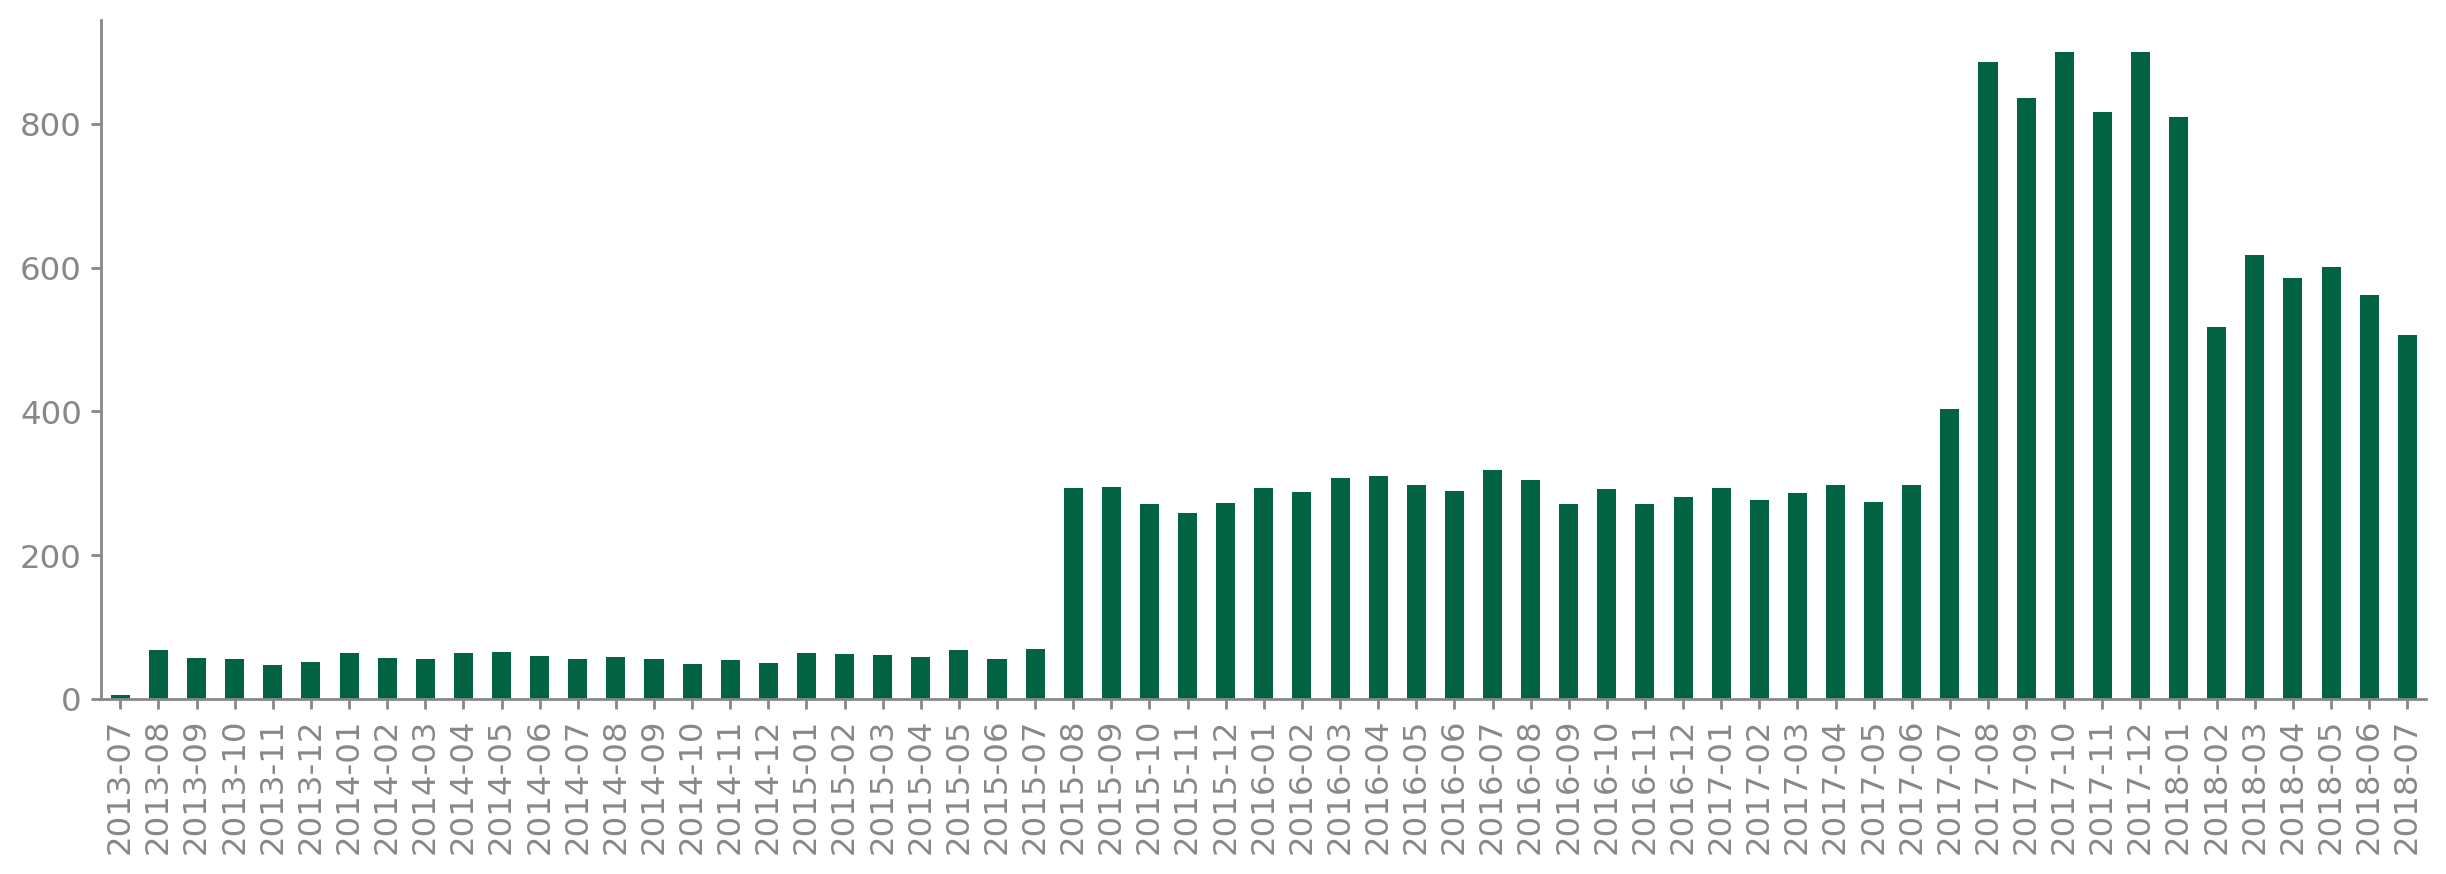

In [278]:
plt.figure(figsize=(15, 4.5))
profile["cohort"].value_counts().sort_index().plot.bar();

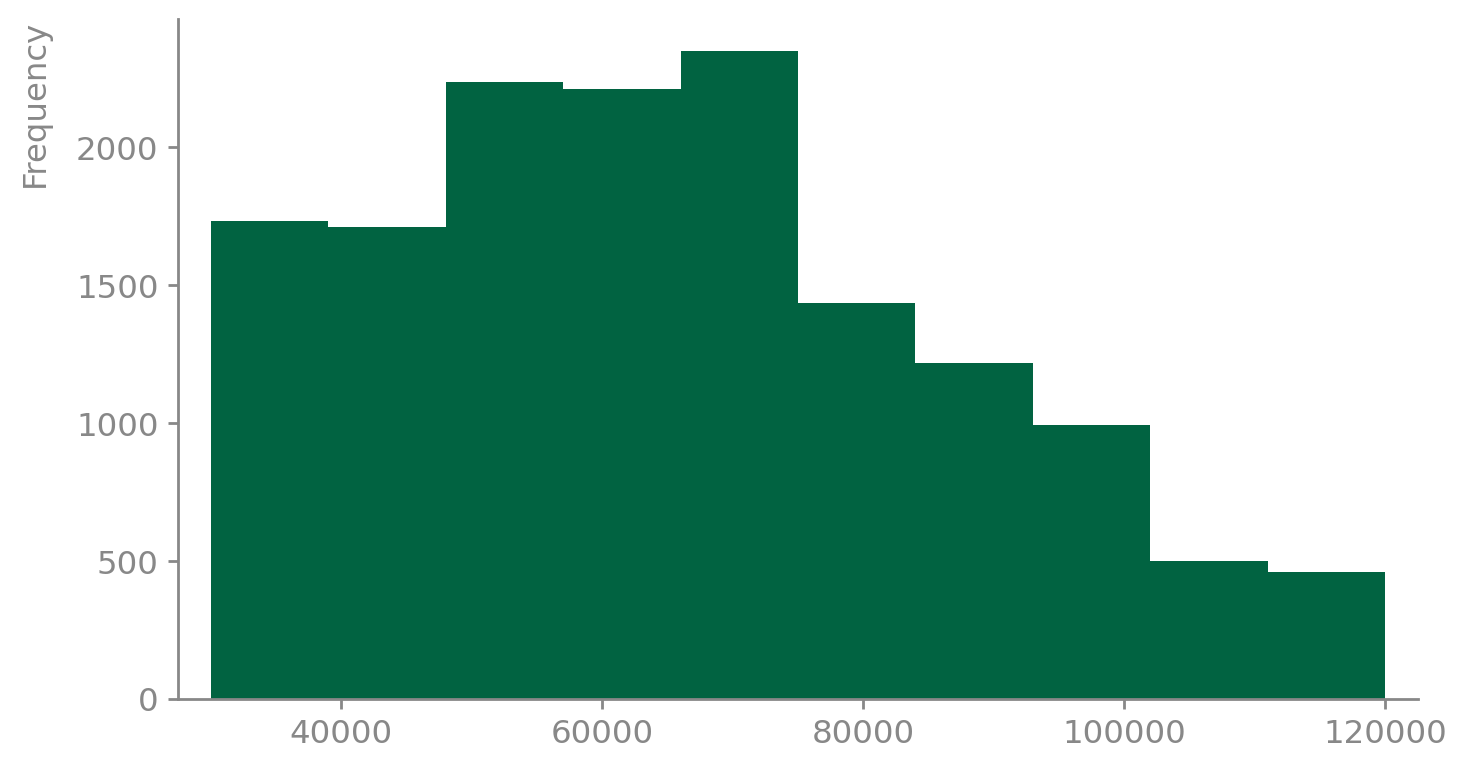

In [279]:
plt.figure(figsize=(8, 4.5))
profile["income"].plot.hist();

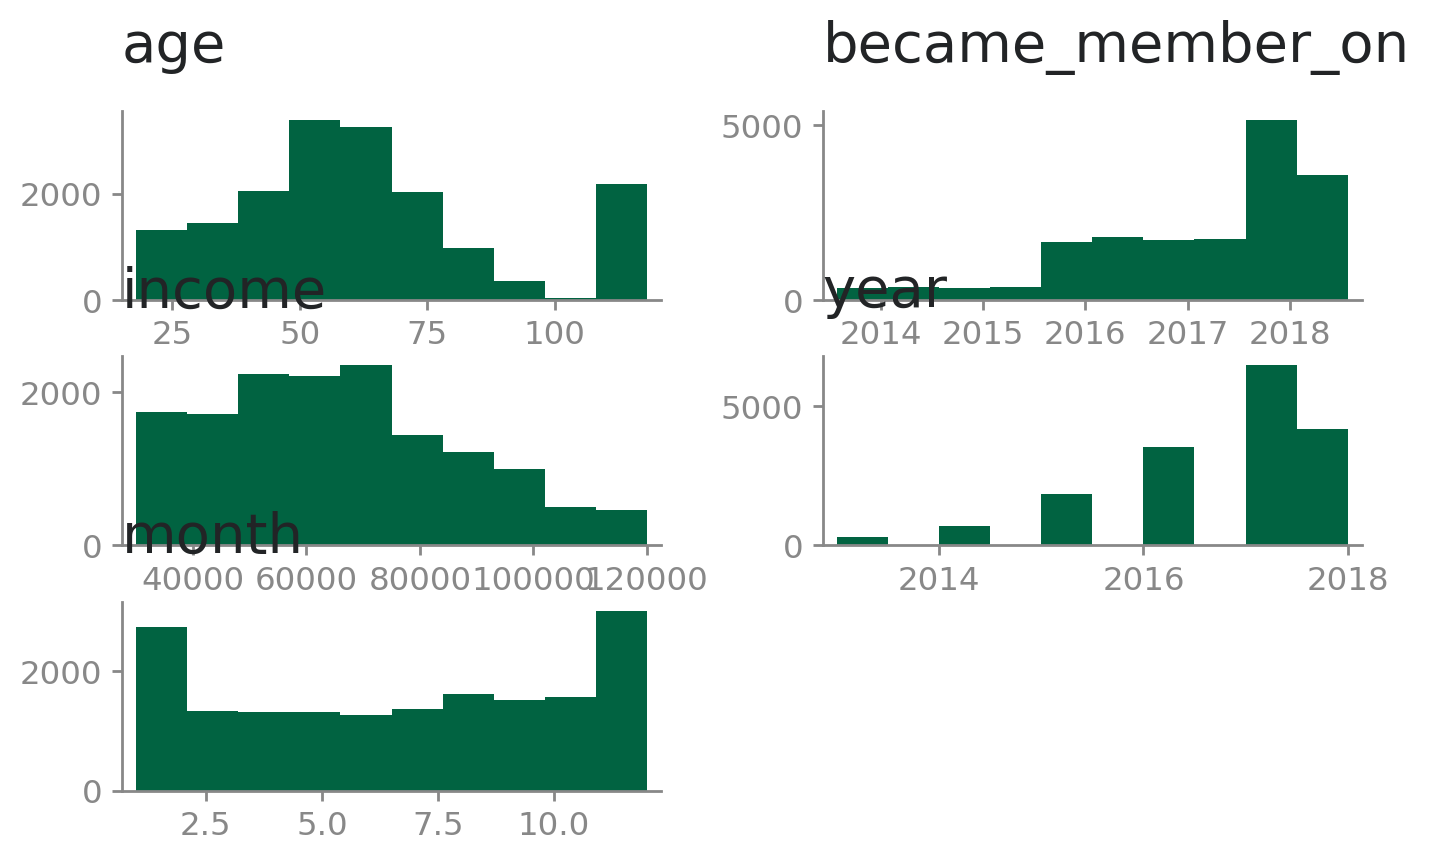

In [280]:
profile.hist();

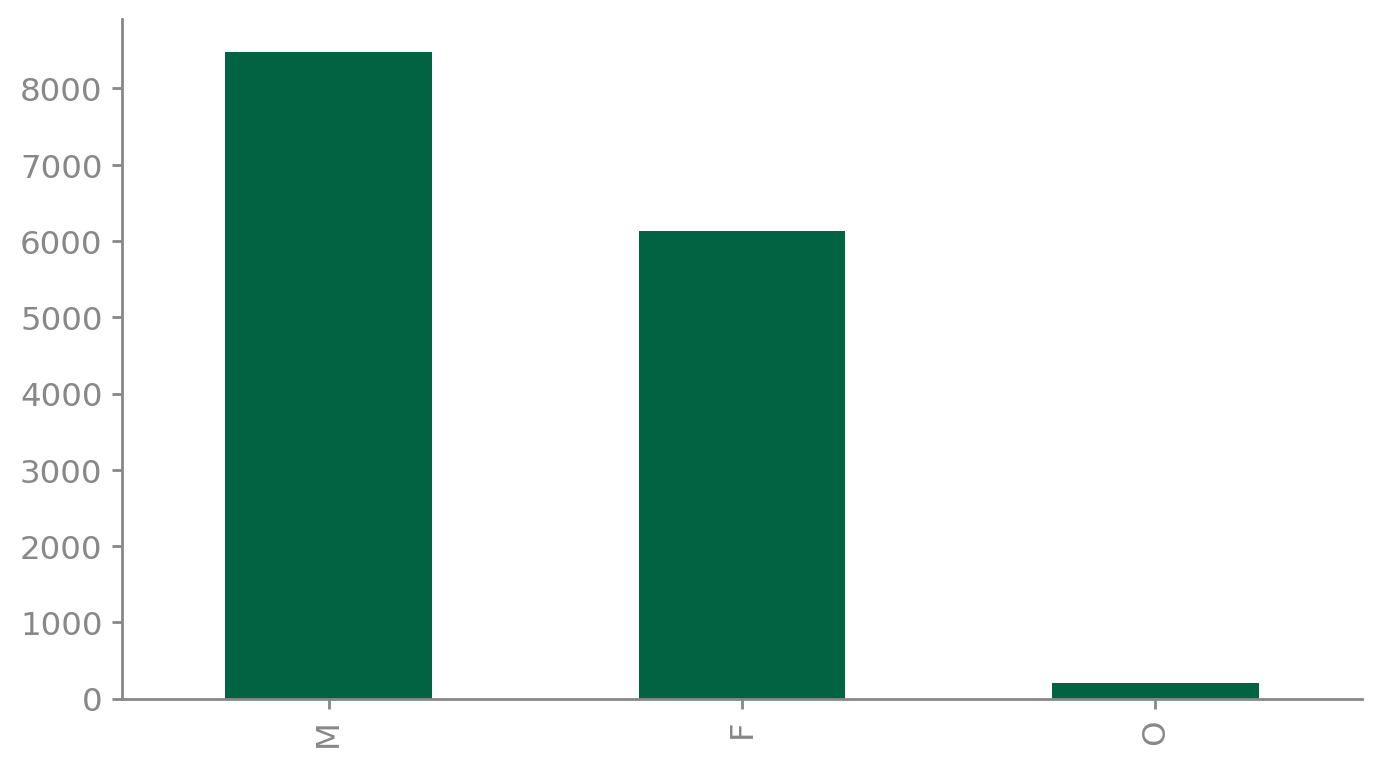

In [281]:
profile["gender"].value_counts().plot.bar();

#### 2.5.2. Visualizing whole transcript

In [283]:
# Showing the first line of each event type
transcript.iloc[[0, 12650, 12654, 12658], :]

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0


In [284]:
# Showing all event types
transcript["event"].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

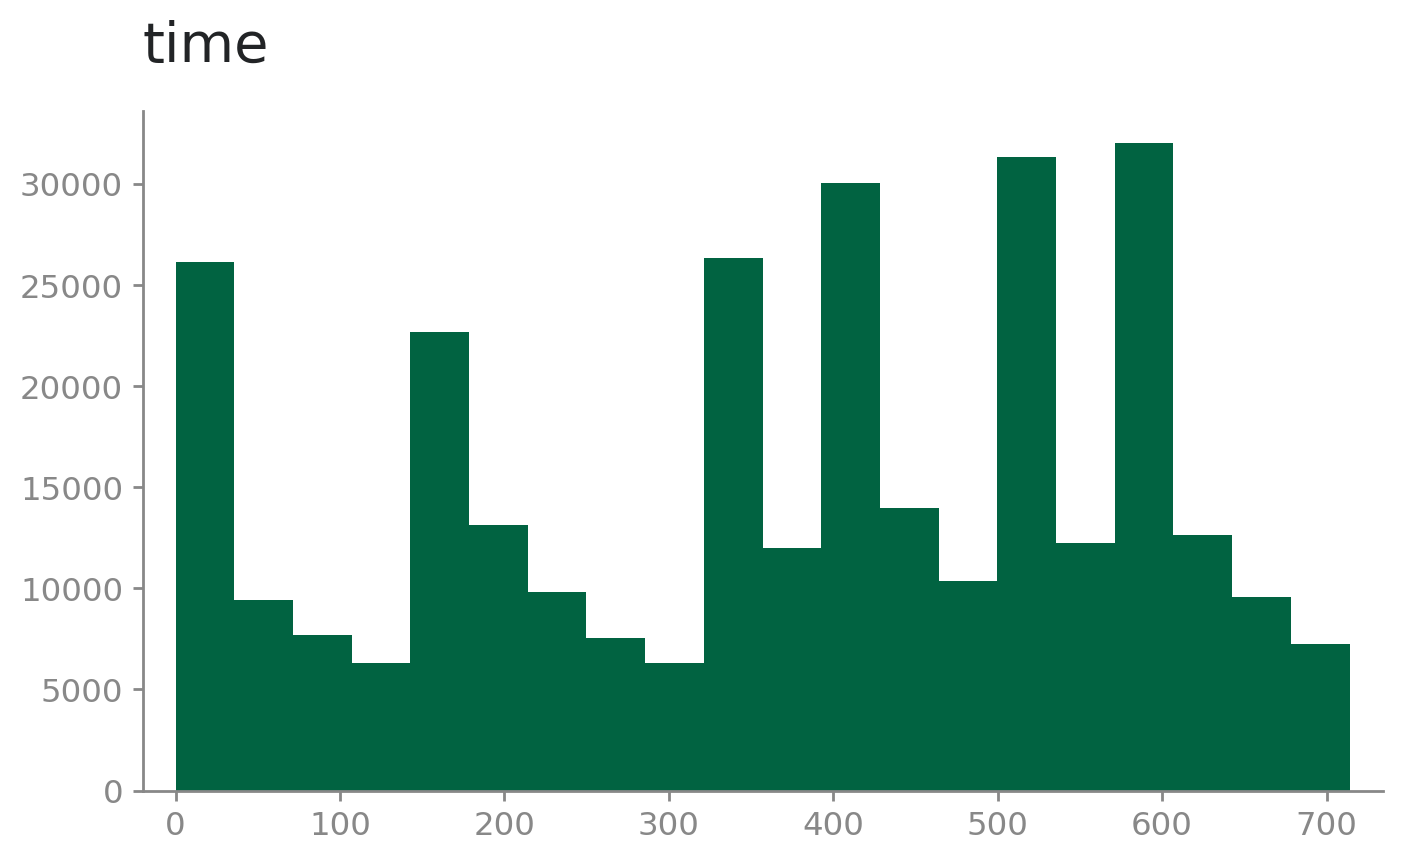

In [285]:
transcript.hist(bins=20);

In [297]:
transcript["offer_id"] = transcript["value"].apply(lambda x: x.get("offer id"))
transcript["amount"] = transcript["value"].apply(lambda x: x.get("amount"))

In [298]:
transcript = pd.merge(transcript, profile, how="left", left_on="person", right_on="id")
transcript = pd.merge(transcript, portfolio, how="left", left_on="offer_id", right_on="id")
transcript.drop(columns=["value", "id_x", "id_y"], inplace=True)
# transcript

In [313]:
transcript.head()

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,118,20170804,NaN,5.0,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68,20180426,70000.0,2.0,"[web, email, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,118,20170925,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,20171002,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo


In [ ]:
# Use a stacked bar chart to plot the histogram of the offer types

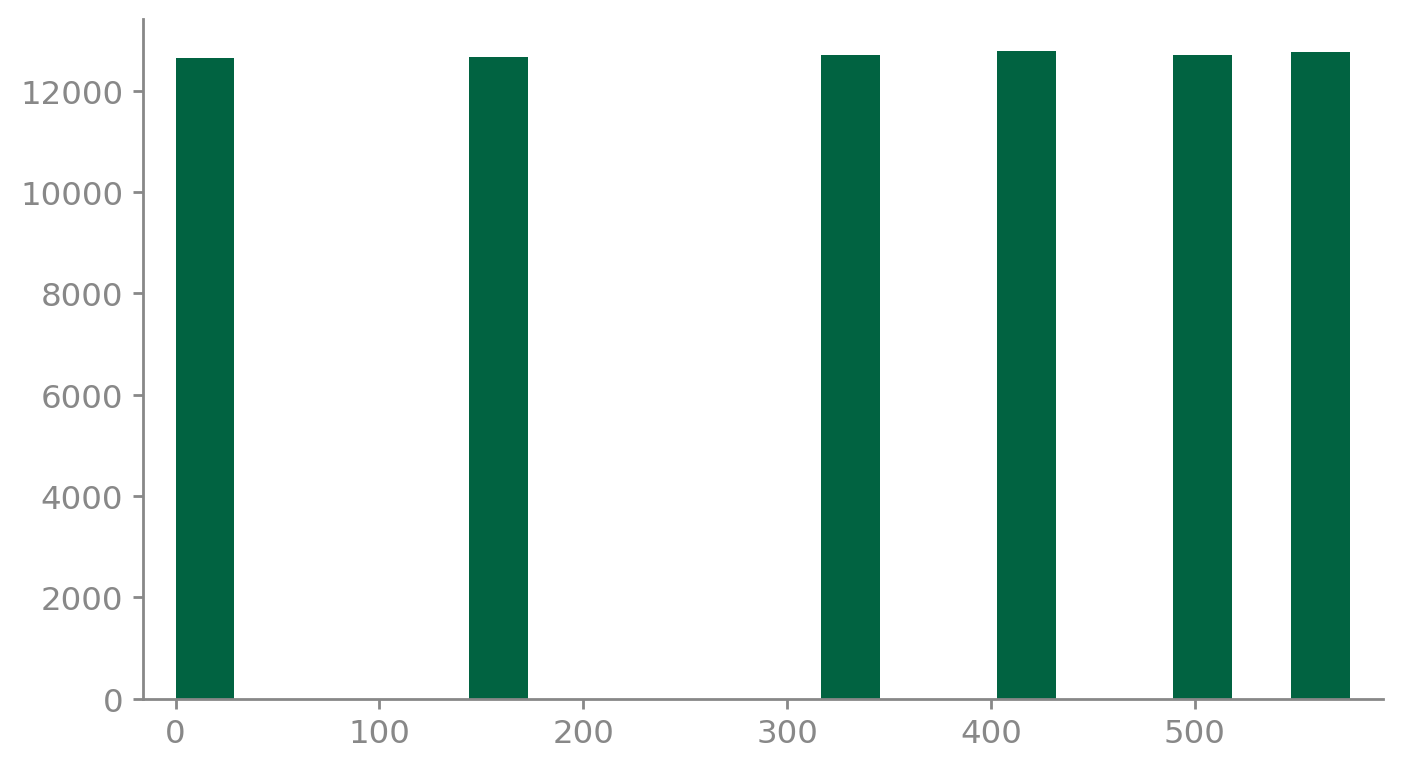

In [307]:
transcript[transcript["event"] == "offer received"]["time"].hist(bins=20);

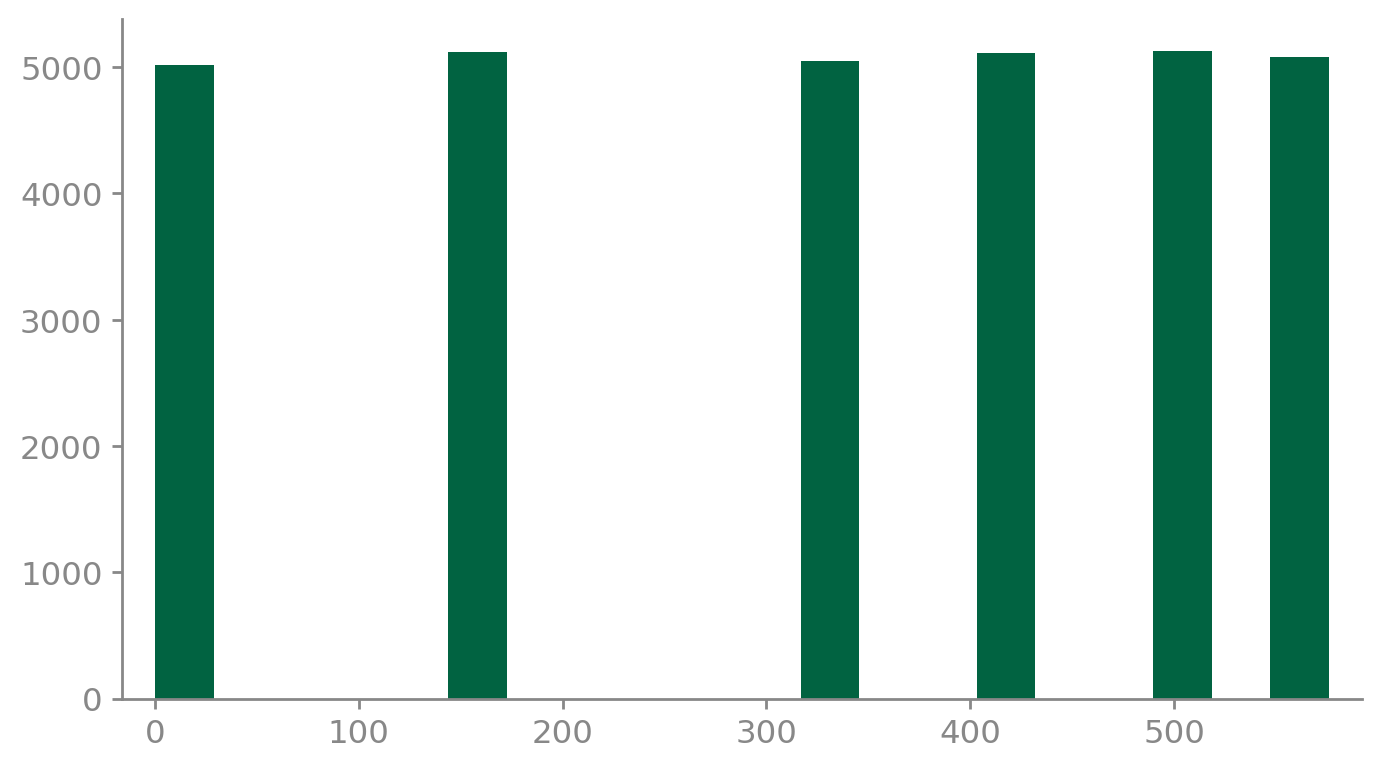

In [310]:
transcript[(
    (transcript["event"] == "offer received")
    & (transcript["offer_type"] == "bogo")
)]["time"].hist(bins=20);

In [336]:
# Use a stacked bar chart to plot the histogram of the bogo types,
# then the discount types and lastly the informational types.

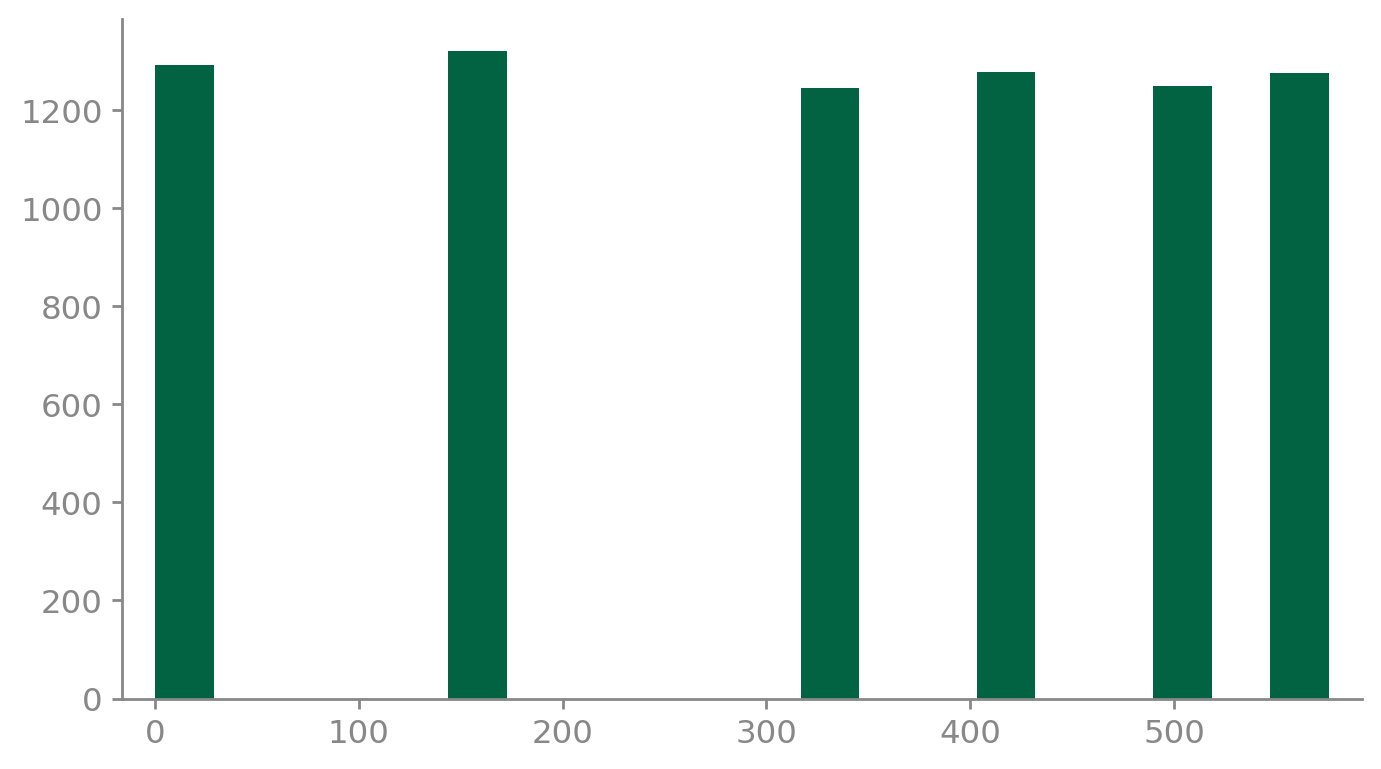

In [334]:
transcript[(
    (transcript["event"] == "offer received")
    & (transcript["offer_type"] == "bogo")
    & (transcript["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd")
)]["time"].hist(bins=20);

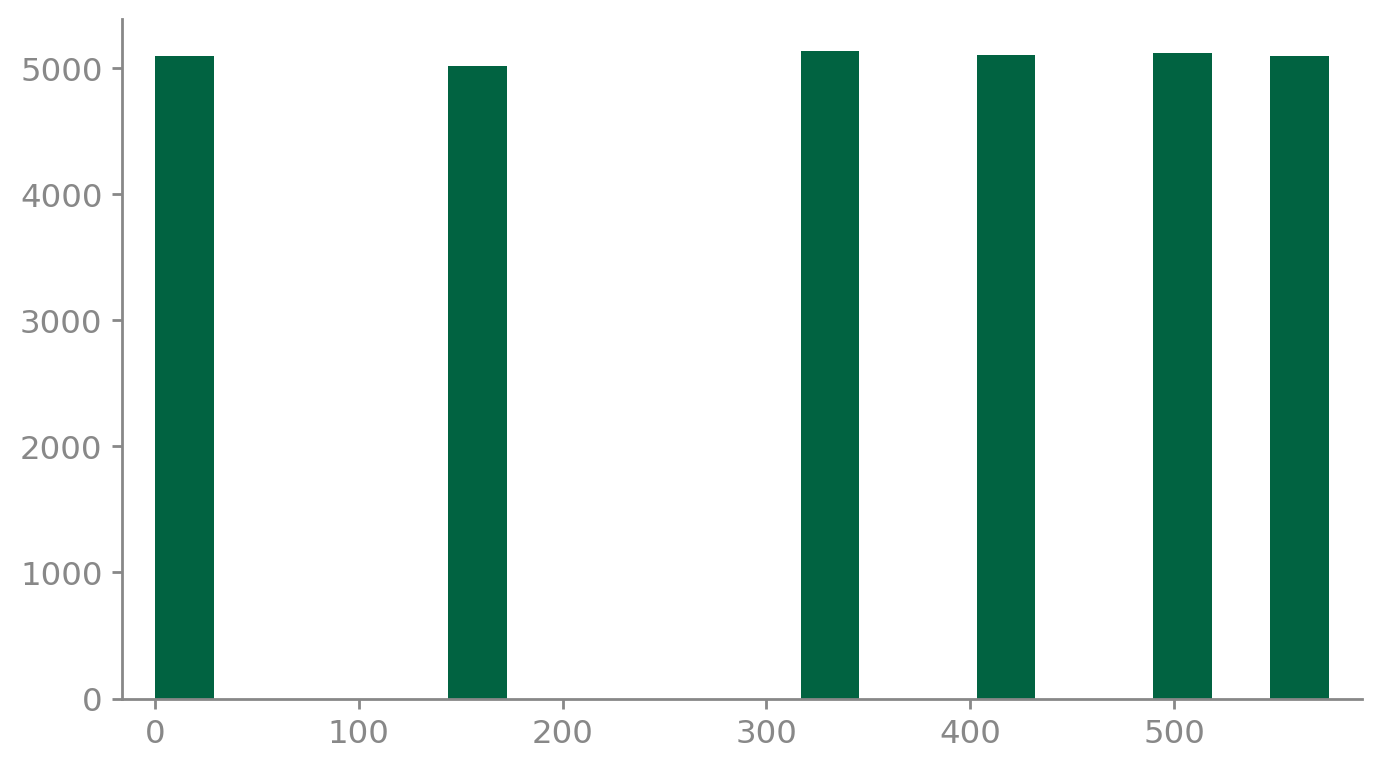

In [311]:
transcript[(
    (transcript["event"] == "offer received")
    & (transcript["offer_type"] == "discount")
)]["time"].hist(bins=20);

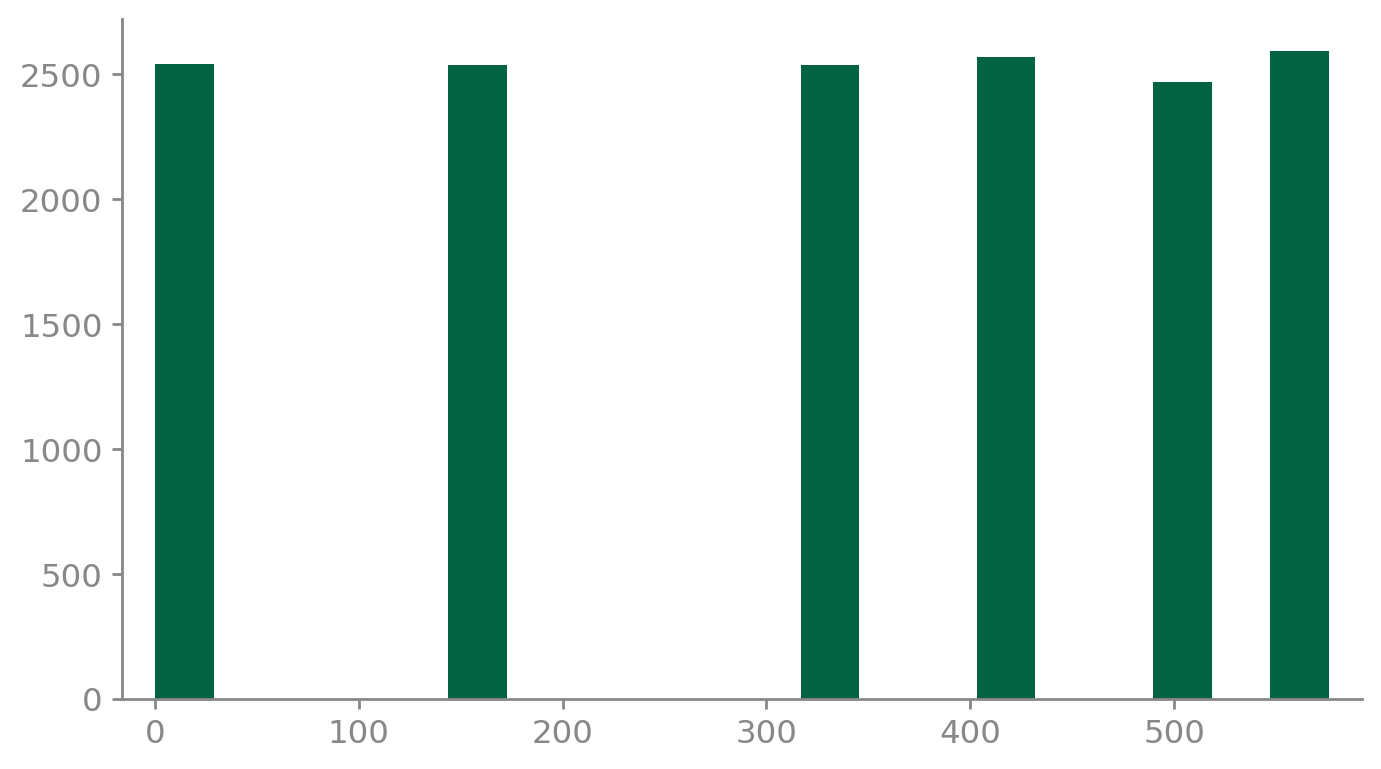

In [312]:
transcript[(
    (transcript["event"] == "offer received")
    & (transcript["offer_type"] == "informational")
)]["time"].hist(bins=20);

In [ ]:
# Remove amount outliers

In [323]:
transcript[(
    (transcript["event"] == "transaction")
    & (transcript["amount"] > 600)
)]["amount"]

18800      628.41
19097      871.51
19845      639.59
20529      656.46
21490      962.10
           ...   
301714     749.29
301790    1015.73
302879     680.70
302951     977.78
305567     685.07
Name: amount, Length: 127, dtype: float64

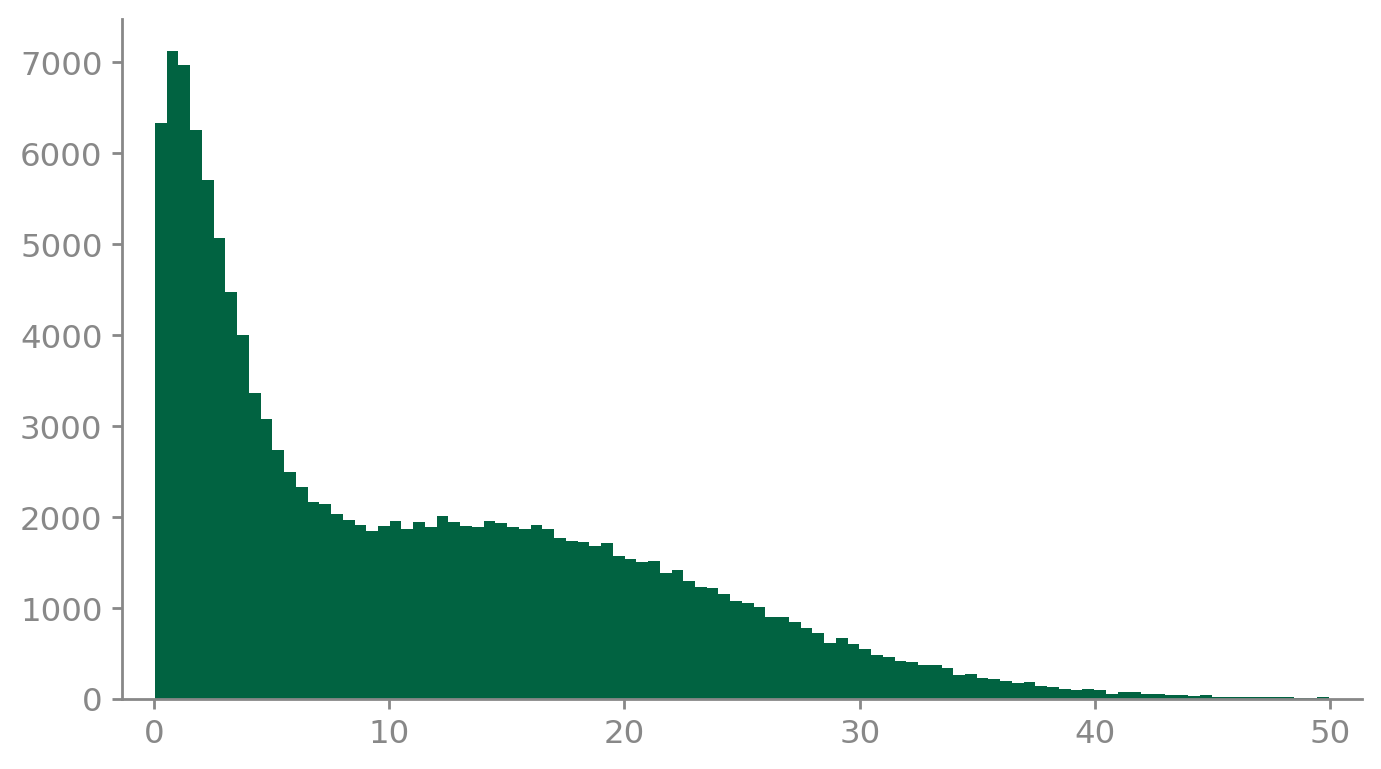

In [321]:
transcript[(
    (transcript["event"] == "transaction")
    & (transcript["amount"] < 50)
)]["amount"].hist(bins=100);

#### 2.5.3. Visualizing transcript per user

In [289]:
df_validity = transcript[transcript["event"] == "offer received"][["time", "duration"]]
df_validity["duration"] = df_validity["duration"].astype(int) * 24 + df_validity["time"]
df_validity["validity"] = df_validity[["time", "duration"]].values.tolist()
# df_validity

In [290]:
transcript = pd.merge(transcript, df_validity["validity"], how="left", left_index=True, right_index=True)
# transcript

In [291]:
df_persons = pd.DataFrame(transcript["person"].unique(), columns=["person_id"])
# df_persons

In [292]:
events = ["offer received", "offer viewed", "transaction", "offer completed"]

In [293]:
def get_event_times(persons, log, column, events):
    for event in events:
        event_times = (
            log[log[column] == event][["person", "time"]]
                .groupby(["person"])
                .agg({"time": lambda x: list(x)})
                .reset_index()
        )
        persons = pd.merge(persons, event_times, how="left", left_on="person_id", right_on="person")
        persons.drop(columns="person", inplace=True)
        persons.rename(columns={"time": event}, inplace=True)
        if event == "offer received":
            validity = (
                log[log[column] == event][["person", "validity"]]
                    .groupby(["person"])
                    .agg({"validity": lambda x: list(x)})
                    .reset_index()
            )
            persons = pd.merge(persons, validity, how="left", left_on="person_id", right_on="person")
            persons.drop(columns="person", inplace=True)
            persons.rename(columns={"time": event}, inplace=True)
    return persons

In [294]:
df_persons = get_event_times(df_persons, transcript, column="event", events=events)
df_persons

,person_id,offer received,validity,offer viewed,transaction,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,"[0, 168, 408, 504]","[[0, 168], [168, 240], [408, 576], [504, 624]]","[6, 216, 408, 582]","[132, 144, 222, 240, 378, 510, 534]","[132, 510, 510]"
1,a03223e636434f42ac4c3df47e8bac43,"[0, 336, 408, 504, 576]","[[0, 240], [336, 432], [408, 480], [504, 744],...","[6, 336, 624]","[234, 264, 612]",NaN
2,e2127556f4f64592b11af22de27a7932,"[0, 336, 408, 504]","[[0, 168], [336, 432], [408, 576], [504, 744]]","[18, 420, 522]","[288, 294, 522]","[522, 522]"
3,8ec6ce2a7e7949b1bf142def7d0e0586,"[0, 168, 336, 408, 504]","[[0, 240], [168, 288], [336, 432], [408, 576],...","[12, 216, 366, 462, 522]",NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,"[0, 168, 336, 408, 504]","[[0, 120], [168, 336], [336, 504], [408, 576],...","[84, 348, 432, 648]","[354, 654]",NaN
...,...,...,...,...,...,...
16995,9fcbff4f8d7241faa4ab8a9d19c8a812,"[504, 576]","[[504, 600], [576, 696]]","[504, 576]",NaN,NaN
16996,ebae5093b436466c9fbd097cb7434023,[576],"[[576, 816]]",[588],"[516, 660]",[660]
16997,912b9f623b9e4b4eb99b6dc919f09a93,[576],"[[576, 696]]",[594],NaN,NaN
16998,3045af4e98794a04a5542d3eac939b1f,[576],"[[576, 696]]",[576],NaN,NaN


In [342]:
transcript[(
    (transcript["event"] == "offer received")
    & (transcript["person"] == "e2127556f4f64592b11af22de27a7932")
)]

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68,20180426,70000.0,2.0,"[web, email, mobile]",10.0,7.0,discount
110830,e2127556f4f64592b11af22de27a7932,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,M,68,20180426,70000.0,0.0,"[web, email, mobile]",0.0,4.0,informational
150600,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68,20180426,70000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo
201574,e2127556f4f64592b11af22de27a7932,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,M,68,20180426,70000.0,2.0,"[web, email, mobile, social]",10.0,10.0,discount


In [343]:
transcript[(
    (transcript["event"] == "offer completed")
    & (transcript["person"] == "e2127556f4f64592b11af22de27a7932")
)]

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
225061,e2127556f4f64592b11af22de27a7932,offer completed,522,None,NaN,M,68,20180426,70000.0,NaN,NaN,NaN,NaN,NaN
225062,e2127556f4f64592b11af22de27a7932,offer completed,522,None,NaN,M,68,20180426,70000.0,NaN,NaN,NaN,NaN,NaN


In [345]:
transcript[(
    (transcript["event"] == "transaction")
    & (transcript["person"] == "e2127556f4f64592b11af22de27a7932")
)]

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
102635,e2127556f4f64592b11af22de27a7932,transaction,288,None,17.88,M,68,20180426,70000.0,NaN,NaN,NaN,NaN,NaN
103834,e2127556f4f64592b11af22de27a7932,transaction,294,None,21.43,M,68,20180426,70000.0,NaN,NaN,NaN,NaN,NaN
225060,e2127556f4f64592b11af22de27a7932,transaction,522,None,18.42,M,68,20180426,70000.0,NaN,NaN,NaN,NaN,NaN


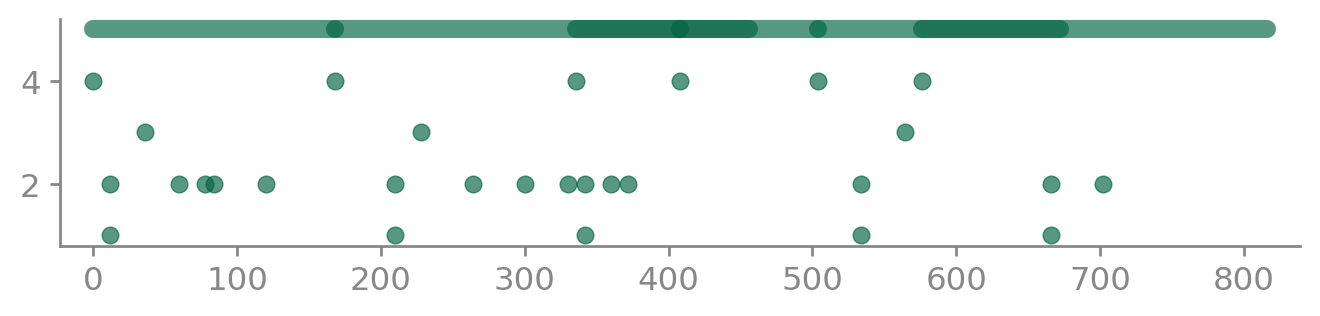

In [363]:
# 7250  # 6 Offers

index = 7250

x2 = df_persons.iloc[index, 1]
y2 = [4] * len(x2)
x3 = df_persons.iloc[index, 3]
y3 = [3] * len(x3)
x4 = df_persons.iloc[index, 4]
y4 = [2] * len(x4)
x5 = df_persons.iloc[index, 5]
y5 = [1] * len(x5)

plt.figure(figsize=(8, 1.5))

for x1 in df_persons.iloc[index, 2]:
    y1 = [5] * len(x1)
    plt.plot(x1, y1, linewidth=6.5, alpha=0.66)

plt.scatter(x2, y2, alpha=0.66)
plt.scatter(x3, y3, alpha=0.66)
plt.scatter(x4, y4, alpha=0.66)
plt.scatter(x5, y5, alpha=0.66)
plt.show()

In [362]:
df_persons[df_persons["person_id"] == "00715b6e55c3431cb56ff7307eb19675"]

,person_id,offer received,validity,offer viewed,transaction,offer completed
7250,00715b6e55c3431cb56ff7307eb19675,"[0, 168, 336, 408, 504, 576]","[[0, 168], [168, 408], [336, 456], [408, 504],...","[36, 228, 564]","[12, 60, 78, 84, 120, 210, 264, 300, 330, 342,...","[12, 210, 342, 534, 666]"


In [370]:
transcript[(
    (transcript["event"] == "offer received")
    & (transcript["person"] == "004b041fbfe44859945daa2c7f79ee64")
)]

,person,event,time,offer_id,amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
56591,004b041fbfe44859945daa2c7f79ee64,offer received,168,3f207df678b143eea3cee63160fa8bed,NaN,F,55,20180508,74000.0,0.0,"[web, email, mobile]",0.0,4.0,informational
204926,004b041fbfe44859945daa2c7f79ee64,offer received,504,f19421c1d4aa40978ebb69ca19b0e20d,NaN,F,55,20180508,74000.0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo
248476,004b041fbfe44859945daa2c7f79ee64,offer received,576,fafdcd668e3743c1bb461111dcafc2a4,NaN,F,55,20180508,74000.0,2.0,"[web, email, mobile, social]",10.0,10.0,discount


In [364]:
transcript[(
    (transcript["event"] == "offer received")
    # & (transcript["person"] == "0009655768c64bdeb2e877511632db8f")  # 5 Offers
    # & (transcript["person"] == "00715b6e55c3431cb56ff7307eb19675")  # 6 Offers
    # & (transcript["offer_type"] == "bogo")
)][["person", "offer_type", "offer_id"]].groupby(["person", "offer_type"]).count().head(50)

offer_id
person                           offer_type             
0009655768c64bdeb2e877511632db8f bogo                  1
                                 discount              2
                                 informational         2
00116118485d4dfda04fdbaba9a87b5c bogo                  2
0011e0d4e6b944f998e987f904e8c1e5 bogo                  1
                                 discount              2
                                 informational         2
0020c2b971eb4e9188eac86d93036a77 bogo                  2
                                 discount              2
                                 informational         1
0020ccbbb6d84e358d3414a3ff76cffd bogo                  2
                                 discount              1
                                 informational         1
003d66b6608740288d6cc97a6903f4f0 discount              3
                                 informational         2
00426fe3ffde4c6b9cb9ad6d077a13ea discount              4
                                 informational         1
004b041fbfe44859945daa2c7f79ee64 bogo                  1
                                 discount              1
                                 informational         1
004c5799adbf42868b9cff0396190900 bogo                  3
                                 discount              2
005500a7188546ff8a767329a2f7c76a bogo                  4
                                 discount              1
0056df74b63b4298809f0b375a304cf4 bogo                  1
                                 discount              2
                                 informational         1
0063def0f9c14bc4805322a488839b32 bogo                  2
                                 discount              2
                                 informational         1
0069a50874d846438e58acff5e594725 discount              3
                                 informational         1
00715b6e55c3431cb56ff7307eb19675 bogo                  2
                                 discount              3
                                 informational         1
0082fd87c18f45f2be70dbcbb0fb8aad bogo                  2
                                 informational         3
00840a2ca5d2408e982d56544dc14ffd bogo                  1
                                 discount              4
                                 informational         1
00857b24b13f4fe0ad17b605f00357f5 bogo                  4
                                 discount              1
008d7088107b468893889da0ede0df5c bogo                  3
                                 discount              1
                                 informational         2
0091d2b6a5ea4defaa8393e4e816db60 bogo                  4
                                 discount              1
0092a132ead946ceb30d11a1ed513d20 bogo                  3
                                 discount              2
                                 informational         1

## 3. Data preparation

## 4. Modelling

## 5. Evaluation

## 6. Deployment